# Dense Sentiment Classifier
IMDB sentiment analysis

In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

## Set hyperparams

In [2]:
# Out dir name
output_dir = 'model_output/dense'

# Training
epochs = 10
batch_size = 128
# Vector-space embedding
n_dim = 64
n_unique_words = 5000 #as per Maas et al (2011); not fully optimal
n_words_to_skip = 50
max_review_len = 100
pad_type = trunc_type = 'pre'

# Neural network architecture
n_dense = 64
dropout = 0.5

## Loading Data
- For this particular Dataset:
    - Keras utils helps quickly preprocess nlp and convert to index https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text
    - the `keras.preprocessing.text.Tokenizer` class may do everything you need in one line:
        - Tokenize into words/characters
        - `num_words` : maximum unique tokens
        - filter out punctuation
        - lower case
        - convert words to an integer index

In [3]:
(x_train, y_train), (x_validation, y_validation) = imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip)

In [4]:
x_train[0:3] # 0 reserved for padding, 1 would be starting character, 2 is unknown, 3 is most common word, etc.

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

In [5]:
for x in x_train[0:3]:
    print(len(x))

218
189
141


In [6]:
len(x_train), len(x_validation)

(25000, 25000)

## Restoring words from index

In [7]:
word_index = tensorflow.keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index['PAD'] = 0
word_index['START'] = 1
word_index['UNKNOWN'] = 2 

In [8]:
# print(word_index)
index_words = {v:k for k,v in word_index.items()}

In [9]:
# x_train[0]
' '.join(index_words[id] for id in x_train[0])

"UNKNOWN UNKNOWN UNKNOWN UNKNOWN UNKNOWN brilliant casting location scenery story direction everyone's really suited UNKNOWN part UNKNOWN played UNKNOWN UNKNOWN could UNKNOWN imagine being there robert UNKNOWN UNKNOWN UNKNOWN amazing actor UNKNOWN now UNKNOWN same being director UNKNOWN father came UNKNOWN UNKNOWN same scottish island UNKNOWN myself UNKNOWN UNKNOWN loved UNKNOWN fact there UNKNOWN UNKNOWN real connection UNKNOWN UNKNOWN UNKNOWN UNKNOWN witty remarks throughout UNKNOWN UNKNOWN were great UNKNOWN UNKNOWN UNKNOWN brilliant UNKNOWN much UNKNOWN UNKNOWN bought UNKNOWN UNKNOWN UNKNOWN soon UNKNOWN UNKNOWN UNKNOWN released UNKNOWN UNKNOWN UNKNOWN would recommend UNKNOWN UNKNOWN everyone UNKNOWN watch UNKNOWN UNKNOWN fly UNKNOWN UNKNOWN amazing really cried UNKNOWN UNKNOWN end UNKNOWN UNKNOWN UNKNOWN sad UNKNOWN UNKNOWN know what UNKNOWN say UNKNOWN UNKNOWN cry UNKNOWN UNKNOWN UNKNOWN UNKNOWN must UNKNOWN been good UNKNOWN UNKNOWN definitely UNKNOWN also UNKNOWN UNKNOWN UNKNOW

In [10]:
(all_x_train,_), (all_x_validation,_) = imdb.load_data()

In [11]:
' '.join(index_words[id] for id in all_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

## Pre-process data

In [12]:
x_train = pad_sequences(x_train, maxlen=max_review_len, padding=pad_type, truncating=trunc_type, value=0)
x_validation = pad_sequences(x_validation, maxlen=max_review_len, padding=pad_type, truncating=trunc_type, value=0)

In [13]:
x_train[0:3]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [14]:
for x in x_train[0:3]:
    print(len(x))

100
100
100


In [15]:
' '.join(index_words[id] for id in  x_train[0])

"cry UNKNOWN UNKNOWN UNKNOWN UNKNOWN must UNKNOWN been good UNKNOWN UNKNOWN definitely UNKNOWN also UNKNOWN UNKNOWN UNKNOWN two little UNKNOWN UNKNOWN played UNKNOWN UNKNOWN UNKNOWN norman UNKNOWN paul UNKNOWN were UNKNOWN brilliant children UNKNOWN often left UNKNOWN UNKNOWN UNKNOWN UNKNOWN list UNKNOWN think because UNKNOWN stars UNKNOWN play them UNKNOWN grown up UNKNOWN such UNKNOWN big UNKNOWN UNKNOWN UNKNOWN whole UNKNOWN UNKNOWN these children UNKNOWN amazing UNKNOWN should UNKNOWN UNKNOWN UNKNOWN what UNKNOWN UNKNOWN done don't UNKNOWN think UNKNOWN whole story UNKNOWN UNKNOWN lovely because UNKNOWN UNKNOWN true UNKNOWN UNKNOWN someone's life after UNKNOWN UNKNOWN UNKNOWN UNKNOWN UNKNOWN us UNKNOWN"

In [16]:
' '.join(index_words[id] for id in  x_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNKNOWN begins better than UNKNOWN ends funny UNKNOWN UNKNOWN russian UNKNOWN crew UNKNOWN UNKNOWN other actors UNKNOWN UNKNOWN those scenes where documentary shots UNKNOWN UNKNOWN spoiler part UNKNOWN message UNKNOWN UNKNOWN contrary UNKNOWN UNKNOWN whole story UNKNOWN UNKNOWN does UNKNOWN UNKNOWN UNKNOWN UNKNOWN'

## NN architecture

In [17]:
model = Sequential()

# First hidden layer
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_len)) # need to embed words in vec space
model.add(Flatten())

# Second hidden layer
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

# Third hidden layer
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                409664    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

In [18]:
# Embedding layer dimensions and params
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [19]:
# Flatten:
max_review_len, n_dim, n_dim*max_review_len

(100, 64, 6400)

In [20]:
# Dense
n_dense, n_dim*max_review_len*n_dense + n_dense

(64, 409664)

In [21]:
# Output layer (64 from prev mapped into 1)
n_dense + 1

65

## Configuring model

In [22]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [23]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

## If output dir doesn't exist

In [24]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    

## Training

In [25]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_validation,y_validation),
         callbacks=[model_checkpoint])

Epoch 1/10
196/196 [==============================] - 4s 21ms/step - loss: 0.6155 - accuracy: 0.6191 - val_loss: 0.3787 - val_accuracy: 0.8302
Epoch 2/10
196/196 [==============================] - 5s 26ms/step - loss: 0.3160 - accuracy: 0.8727 - val_loss: 0.3532 - val_accuracy: 0.8431
Epoch 3/10
196/196 [==============================] - 5s 25ms/step - loss: 0.1325 - accuracy: 0.9553 - val_loss: 0.5028 - val_accuracy: 0.8263
Epoch 4/10
196/196 [==============================] - 4s 22ms/step - loss: 0.0370 - accuracy: 0.9894 - val_loss: 0.7119 - val_accuracy: 0.8224
Epoch 5/10
196/196 [==============================] - 4s 22ms/step - loss: 0.0126 - accuracy: 0.9966 - val_loss: 0.9522 - val_accuracy: 0.8233
Epoch 6/10
196/196 [==============================] - 4s 22ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 1.0132 - val_accuracy: 0.8246
Epoch 7/10
196/196 [==============================] - 4s 22ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 1.1486 - val_accuracy: 0.8216

## Evalutation 

In [54]:
model.load_weights(output_dir+"/weights.10.hdf5") # starts from 1-epochs

In [55]:
y_hat = model.predict(x_validation)
len(y_hat)

25000

In [56]:
y_hat[0]

array([0.9731178], dtype=float32)

In [57]:
y_validation[0]

0

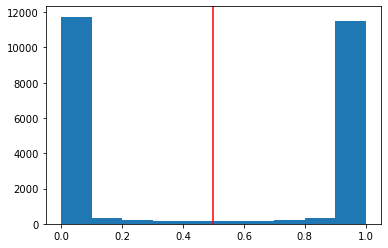

In [58]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='red')

In [59]:
pct_auc = roc_auc_score(y_validation, y_hat)*100
'{:0.2f}'.format(pct_auc)

'90.14'

In [60]:
float_y_hat = [y[0] for y in y_hat]

In [61]:
ydf = pd.DataFrame(list(zip(float_y_hat,y_validation)),columns=['y_hat','y'])

In [62]:
ydf.head(10)

,y_hat,y
0,9.731178e-01,0
1,9.999990e-01,1
2,9.962897e-01,1
3,6.446213e-02,0
4,1.000000e+00,1
5,1.742277e-02,1
6,9.999992e-01,1
7,3.280664e-07,0
8,1.820416e-01,0
9,9.997489e-01,1


In [63]:
' '.join(index_words[id] for id in all_x_validation[0])

"START please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

In [64]:
' '.join(index_words[id] for id in all_x_validation[3])

"START i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are impossibly involved with the actions on the screen so then why the hell can't we have night vision"

In [65]:
ydf[(ydf.y ==0) & (ydf.y_hat >0.9)].head()

,y_hat,y
0,0.973118,0
59,0.999721,0
66,0.999996,0
92,0.961222,0
112,0.999970,0


In [69]:
' '.join(index_words[id] for id in all_x_validation[112]) #Not very good engrish, got classified incorrectly

'START if you want to see a horror film which is horrible and in very bad taste this is definitely the film to view this films starts out with two young teenagers getting wild ideas about going into a chat room and going out on blind dates and quite possibly they will wind up like a little lamb to the slaughter house plenty of blood gore nudity handcuffs and all kinds of blood draining hooks and things you will never dream a person is capable of performing on men and women if you like piercing well this kind of piercing deals with heavy heavy hooks and plenty of besides lots of needles and thread to seal up things on the human body i really hope that this film does not give some sick person in this world the idea to act out these horrors in real life'

In [67]:
ydf[(ydf.y ==1) & (ydf.y_hat <0.1)].head()

,y_hat,y
5,0.017423,1
31,0.011729,1
43,0.043862,1
45,0.007054,1
55,0.002513,1


In [70]:
' '.join(index_words[id] for id in all_x_validation[55])

"START this is a special film if you know the context antonioni in his eighties had been crippled by a stroke mute and half paralyzed his friends who incidentally are the best the film world has arranged for him to a last significant film the idea is that he can conjure a story into being by just looking at it so we have a film about a director who conjures stories by simple observation and the matter of the four stories is about how the visual imagination defines love br br the film emerges by giving us the tools to bring it into being through our own imagination the result is pure movie world every person except the director is lovely in aspect or movement some of these women are and they exist in a dreamy misty world of sensual encounter there is no nuance no hint that anything exists but what we see no desire is at work other than what we create br br i know of no other film that so successfully manipulates our own visual yearning to have us create the world we see he understands s